In [1]:
import numpy as np
import scipy.sparse.linalg as LA
import matplotlib.pyplot as plt
from collections import defaultdict
%matplotlib inline
plt.rcParams['figure.figsize'] = 16, 9

In [2]:
class Heisenberg:
    def __init__(self, L, nup, periodic=False, j=1.):
        self.L = L
        self.j = j
        self.nup = nup
        self.periodic = periodic
        
        self.index = {} # this maps a state s to its index in states
        states = []
        ## find all basis states with given nup
        
        for s in range((2**nup)-1, 2**self.L):
            if bin(s).count('1')==self.nup: #use gmpy2.popcount for efficiency
                self.index[s] = len(states)
                states.append(s)
        
        self.states = np.array(states,dtype=int)
        self.N = len(self.states)
    
    def multiply(self,x):
        assert(len(x)==self.N)
        y = np.zeros_like(x)
        # diagonal part
        for i, s in enumerate(self.states):
            # s     : 010001011
            # s>>1  : 001000101 #last 1 is lost
            # xor   : 011001110
            # our xor pattern now tells us when we change from 0 to 1 or 1 to 0
            breaks = s^(s >> 1)
            jtotal = 0
            
            # go through the non periodic chain (L-1 connections in L spins)
            for r in range(self.L-1):
                if breaks&(1<<r): #bit r is set
                    jtotal -= 1
                    # off-diagonal part
                    sflipped = s^(3 << r)
                    # 3 is 11 in binary, so it flips 10 to 01
                    y[self.index[sflipped]] += 0.5*self.j*x[i]
                else:
                    jtotal += 1

            if self.periodic:
                # s^(s>>1) does not work in a periodic manner, we have to fix
                #
                # this manually: what we do is shifting by L-1
                # s     : 010001011
                # s>>L-1:         010001011
                # xor   : 000000001
                breaks = s^(s >> (self.L-1))
                if breaks&1:
                    jtotal -= 1
                    # off-diagonal part
                    sflipped = s^(1|(1 << (self.L-1)))
                    # 1|(1<<L-1) is 10000000001 and flipes our state s
                    y[self.index[sflipped]] += 0.5*self.j*x[i]
                else:
                    jtotal += 1
        
            y[i] += 0.25*self.j*jtotal*x[i]
        return y


# Test Energies

In [3]:
from sortedcontainers.sortedlist import SortedList # pip install sortedcontainers
E = {True:defaultdict(SortedList), False:defaultdict(SortedList)}

Lmin, Lmax = 4, 12

LENGTHS = np.arange(Lmin, Lmax)

for L in LENGTHS:
    for i in range(2):
        for periodic in E.keys():
            nup = L // 2 + i
            
            heis_o = Heisenberg(L,nup,periodic=periodic)
            H = LA.LinearOperator( (heis_o.N,heis_o.N), matvec=heis_o.multiply)
            w,_ = LA.eigsh(H, 2, which='SA')
            E[periodic][L].update(w)

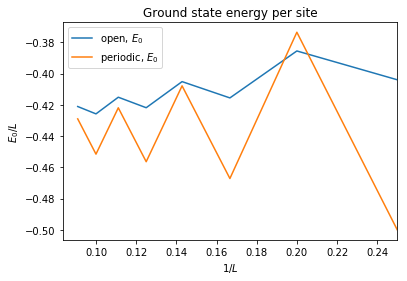

In [4]:
plt.figure()
for i in range(1):
    plt.plot(1/LENGTHS,[E[False][l][i] / l for l in LENGTHS],label='open, $E_{}$'.format(i))
    plt.plot(1/LENGTHS,[E[True][l][i] / l for l in LENGTHS],label='periodic, $E_{}$'.format(i))
plt.xlim([1/Lmax,1/Lmin])
plt.title('Ground state energy per site')
plt.xlabel('$1/L$')
plt.ylabel('$E_0/L$')
plt.legend()
plt.show()

In [5]:
from IPython.display import Image
from IPython.display import display
display(Image(url="exchange_energies_L6.png", width=300), Image(url="exchange_energies_L7.png", width=300))

Figure 2: Strength of the local contribution of each bond to the Heisenberg Hamiltonian
for even and odd open chains.

In Figure 1 we observe the oscillation of the ground state energy between even and odd number of sites in both lattice topologies. In the case of periodic boundary conditions this is easily understood by the appearance of a frustrated spin in an odd chain, i.e. one spin can align in order to favor the bond with the previous spin, or with the next spin, but not both at the same time.

For an open chain there is no apparent frustration, but the increase in energy per site can still be understood from the local contributions to the Heisenberg Hamiltonian as shown in Figure 2. The major contribution to the ground state comes from the dimerized state, i.e. a chain of singlets: this is only possible in an even chain (see left panel). In the odd chain (right panel) the system tries to build singlets from both boundaries, which is again giving rise to frustration in the center where the two incompatible dimer patterns meet. In the thermodynamic limit L → ∞ the difference between even and odd length vanishes.

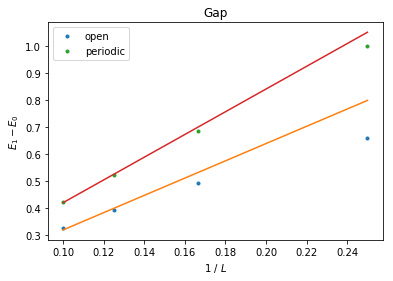

In [6]:
tasks = [('open', E[False]), ('periodic', E[True])]

# create two figures
plt.figure()
plt.title('Gap')
plt.xlabel('1 / $L$')
plt.ylabel('$E_1-E_0$')

for name, data in tasks:
    # load data
    lengths_even = np.array([l for l in LENGTHS if l % 2 == 0])
    
    e0 = np.array([data[l][0] for l in lengths_even])
    e1 = np.array([data[l][1] for l in lengths_even])
    
    gap = (e1 - e0)
    
    # fit to form y = m*x = m/L for the 4 largest chains
    invlen = 1 / lengths_even
    numpoints = 2

    m = np.linalg.lstsq(np.vstack(invlen[-numpoints:]), gap[-numpoints:], rcond=None)[0]
    
    # plot gap and 1/L fit
    plt.plot(invlen, gap, '.',label=name)
    plt.plot(invlen, m * invlen)

plt.legend()
plt.show()

By targeting the two lowest eigenenergies in the Lanczos solver (or a similar iterative
eigensolver) for each quantum number sector we identify the smallest excitation from the
ground state. The energy gap nicely extrapolates to zero $∼ 1 / L^1$.